# Телеком

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Изучение данных

In [1]:
pip install phik


     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 45 kB/s s eta 0:00:01     |█████████████████               | 16.4 MB 44.6 MB/s eta 0:00:01     |██████████████████████████████▍ | 29.2 MB 12.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

import warnings 
warnings.filterwarnings('ignore')

In [4]:
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
RANDOM_STATE = 250423

### Договор 

In [6]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


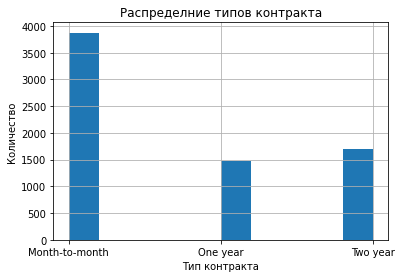

In [9]:
df_contract['Type'].hist()
plt.title("Распределние типов контракта")
plt.xlabel("Тип контракта")
plt.ylabel("Количество");


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> подправил.</div>

In [10]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors ='coerce')

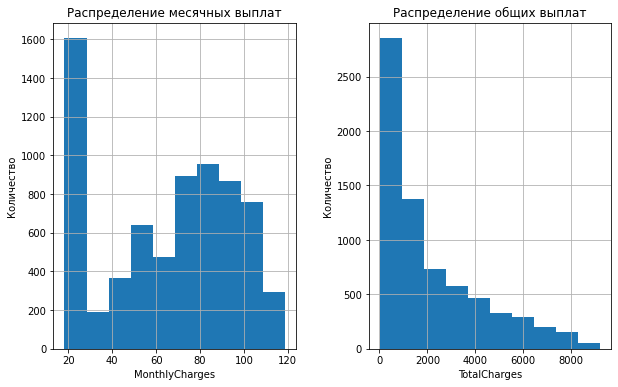

In [11]:
df_contract.hist(figsize =(10, 6));
plt.subplot(121)
plt.title("Распределение месячных выплат")
plt.xlabel("MonthlyCharges")
plt.ylabel("Количество")

plt.subplot(122)
plt.title("Распределение общих выплат")
plt.xlabel("TotalCharges")
plt.ylabel("Количество");

**Признаки**


- customerID — код клиента
- BeginDate — дата начала пользования услугами
- EndDate — дата окончания пользования услугами
- Type — тип договора(месячный/годовой)
- PaperlessBilling — факт выставления счета на эл. почту
- PaymentMethod — способ оплаты
- MonthlyCharges — ежемесячные траты на услуги
- TotalCharges — всего потрачено денег на услуги

**Выводы**
- пропусков нет
- необходимо изменить типы данных для большинста столбцов(даты/числа/категории)
- Для визуализации TotalCharges я изменил тип данных, однако я заметил что там есть ошибки, далее надо будет изучить природу этих ошибок

### Персональные данные 

In [12]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

In [15]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].astype('object')

**Признаки**


- customerID — код клиента
- gender — пол
- SeniorCitizen — является ли клиент пенсионером
- Partner — наличие партнера
- Dependents — наличие иждевенца 

**Выводы**
- пропусков нет
- необходимо изменить типы данных для большинста столбцов(числа/категории)

### Интернет 

In [16]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Признаки**

В данном датасете написана информация о том какие услуги по интурнету подключены пользователям:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)

а также:
- InternetService - тип подключения

**Выводы**
- пропусков нет, однако строк меньше чем в df_personal и df_contract. Следовательно не у всех подключен интернет.
- необходимо изменить типы данных для большинста столбцов(категории)

### Телефон 

In [18]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5842-POCOP,No
freq,1,3390


**Признаки**

Ситуация подобная датасету по интернет-услугам, не у всех пользователей подключены услуги телефонной связи(MultipleLines - возможность параллельных линий во время звонка)

**Выводы**
- пропусков нет, однако строк меньше чем в df_personal и df_contract. Следовательно не у всех подключены услуги телефонной связи.
- необходимо изменить типы данных для столбца(категории)

### План
1. Предобработать данные, т. е. более детально изучить признаки, изучить природу замеченных ошибок и испарвить их. Изучить наличие аномалий, заполнить пропуски, которые появятся после объединений таблиц. Также необходимо будет отбросить некоторые столбцы и добавить целевой признак.

2. Создать трейн и тест выборки, для леса и для линейных моделей необходимо использовать разное кодирование(OHE для линейных и OE для леса).

3. Попробовать линейные модели(регрессию и лассо), случайный лес и бустинги. Перебрать параметры на кросс валидации.

4. Протестировать модель которая лучше всего показала себя на 3 шаге. 

5. Анализ финальной модели(важность признаков, матрица ошибок)

6. проверка адекватности модели при помощи Dummy models.

## Предобработка данных

### Объединение таблиц

In [21]:
df = (df_contract.merge(df_personal, how='left',on='customerID')
      .merge(df_internet, how='left',on='customerID') 
      .merge(df_phone, how='left',on='customerID'))

In [22]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
df.isnull().any()

customerID          False
BeginDate           False
EndDate             False
Type                False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
InternetService      True
OnlineSecurity       True
OnlineBackup         True
DeviceProtection     True
TechSupport          True
StreamingTV          True
StreamingMovies      True
MultipleLines        True
dtype: bool

Видно, что после соединения появились пропуски в столбцах связанных с услугами. Это значит что эти услуги не предоставляются, так что их мы просто заполним 'No'. У TotalCharges другая природа, ее изучим позже

In [24]:
services =['InternetService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 
           'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'MultipleLines']

In [25]:
df[services] = df[services].fillna('No')

In [26]:
df.isnull().any()

customerID          False
BeginDate           False
EndDate             False
Type                False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
MultipleLines       False
dtype: bool

### Работа с датой

Заменим No на актуальную для данных дату, чтобы выделить новый признак, говорящий о том сколько времени клиент пользуется услугами компании, а даты впоследствии удалим перед обучением модели.

In [27]:
df['EndDate'] = df['EndDate'].replace(['No'], '2020-02-01')

In [28]:
df[['BeginDate', 'EndDate']] = df[['BeginDate', 'EndDate']].apply(pd.to_datetime)

In [29]:
df['CLC'] = df['EndDate'] - df['BeginDate'] 
df['CLC'] = df['CLC'].dt.days

In [30]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CLC
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


### пропуски в TotalCharges

In [31]:
df[df['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CLC
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Как видно по дате, это новички. Размер данных небольшой, так что удалим их.

In [32]:
df.dropna(inplace=True)

### Выделение целевого признака

In [33]:
df.set_index('customerID', inplace = True)

In [34]:
df['Churn'] = (df['EndDate'] != '2020-02-01').astype(int)

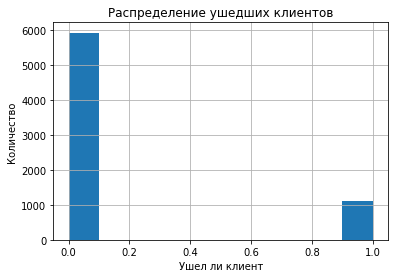

In [35]:
df['Churn'].hist()
plt.title("Распределение ушедших клиентов")
plt.xlabel("Ушел ли клиент")
plt.ylabel("Количество");

In [36]:
df.drop(['BeginDate', 'EndDate'], axis=1, inplace = True)

### Проверка корреляции

In [37]:
interval_cols =['MonthlyCharges', 'TotalCharges', 'CLC']

In [38]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)

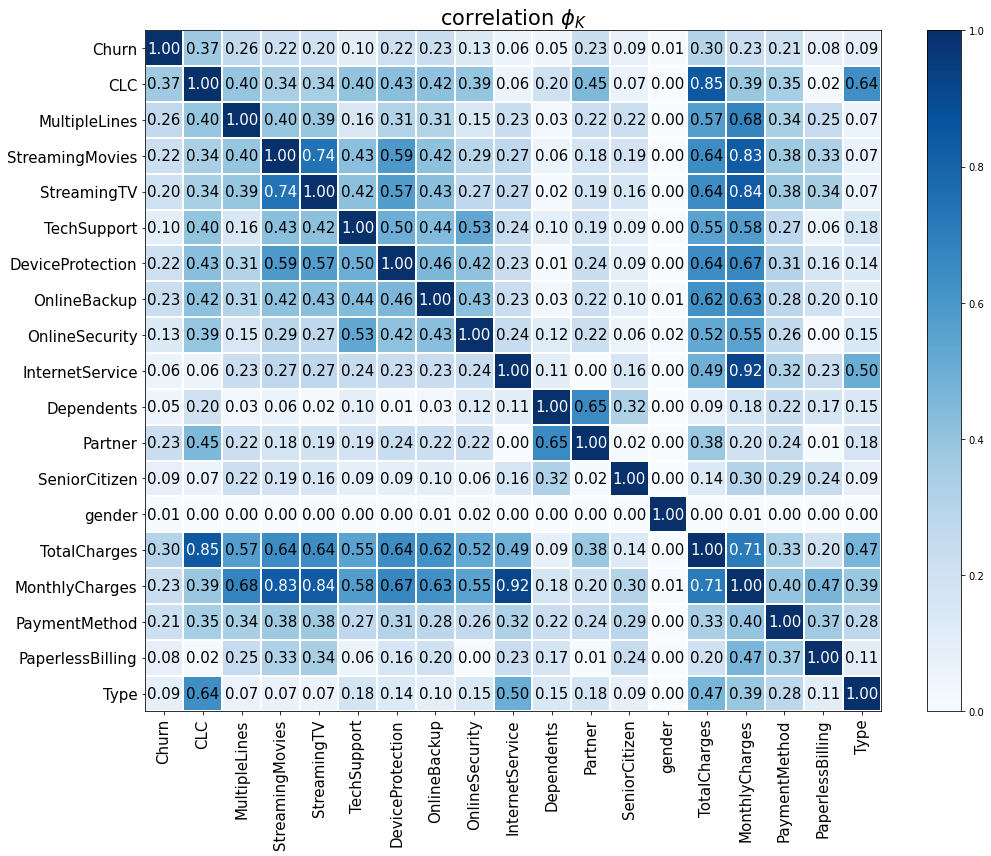

In [39]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,12))
plt.tight_layout()

Удалим столбцы с высокой корреляцией для логистической регрессии в работе с выборками

## Работа с выборками

### Создание тренировочной и тестовой выборки

In [40]:
features = df.drop(['Churn'], axis=1)
target = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [41]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [42]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [43]:
X_train_lr.drop(['TotalCharges', 'StreamingMovies', 'StreamingTV','InternetService'], axis=1, inplace = True)
X_test_lr.drop(['TotalCharges', 'StreamingMovies', 'StreamingTV','InternetService'], axis=1, inplace = True)

### Кодирование для линейных моделей

In [44]:
ohe_features = X_train_lr.select_dtypes(include='object').columns.to_list()
ohe_features.remove('SeniorCitizen')
ohe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'MultipleLines']

In [45]:
num_features = X_train_lr.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'CLC']

In [46]:
scaler = StandardScaler()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train_lr[ohe_features])


X_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_lr[ohe_features])

X_train_lr = X_train_lr.drop(ohe_features, axis=1)

X_train_lr[num_features] = scaler.fit_transform(X_train_lr[num_features])
X_train_lr.head()

,MonthlyCharges,SeniorCitizen,CLC,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,
4189-NAKJS,-0.434285,0,-0.156048,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6504-VBLFL,-0.201467,0,1.133510,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
9040-KZVWO,0.356636,0,-0.156048,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0771-CHWSK,0.326914,0,1.620741,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
3981-QSVQI,-1.486094,0,-0.953998,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:

X_test_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_lr[ohe_features])

X_test_lr = X_test_lr.drop(ohe_features, axis=1)


X_test_lr[num_features] = scaler.transform(
    X_test_lr[num_features]
)

X_test_lr.head()

,MonthlyCharges,SeniorCitizen,CLC,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,
2049-BAFNW,-0.951108,0,-1.266176,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9369-XFEHK,0.525057,1,0.245115,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2790-XUYMV,0.685223,0,1.843934,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2664-XJZNO,1.327536,0,1.884779,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1684-FLBGS,0.158493,0,-0.287338,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [48]:
X_train_lr.columns

Index(['MonthlyCharges', 'SeniorCitizen', 'CLC', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'MultipleLines_Yes'],
      dtype='object')

### Кодирование для деревьев

In [49]:
oe_features = X_train_rf.select_dtypes(include='object').columns.to_list()
oe_features.remove('SeniorCitizen')
oe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [50]:
encoder_oe = OrdinalEncoder()
X_train_rf[oe_features] = encoder_oe.fit_transform(X_train_rf[oe_features])
X_test_rf[oe_features]= encoder_oe.transform(X_test_rf[oe_features])

## Работа с моделями

### Логистическая регрессия

In [51]:
grid={'C': [0.001, 0.01, 0.1, 1, 10, 15, 20], 
      "penalty":["l1","l2"]}
logreg=LogisticRegression(solver="liblinear", random_state=RANDOM_STATE)
logreg_cv=GridSearchCV(logreg,
                       grid,
                       cv=5, 
                       scoring='roc_auc',
                       n_jobs=-1)
logreg_cv.fit(X_train_lr, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("roc_auc :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 20, 'penalty': 'l2'}
roc_auc : 0.7501767795804568


### Катбуст

In [52]:
X_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CLC
customerID,,,,,,,,,,,,,,,,,,
4189-NAKJS,One year,Yes,Credit card (automatic),51.55,1434.12,Male,0,No,No,DSL,No,No,No,No,No,No,Yes,792
6504-VBLFL,Two year,No,Electronic check,58.60,3351.92,Male,0,Yes,No,DSL,Yes,Yes,Yes,No,No,No,No,1676
9040-KZVWO,One year,No,Bank transfer (automatic),75.50,2041.52,Male,0,No,No,Fiber optic,No,Yes,No,No,No,No,No,792
0771-CHWSK,Two year,Yes,Credit card (automatic),74.60,5071.31,Male,0,No,No,DSL,Yes,Yes,Yes,No,No,Yes,Yes,2010
3981-QSVQI,Month-to-month,Yes,Bank transfer (automatic),19.70,159.18,Male,0,No,No,No,No,No,No,No,No,No,No,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669-WHAFY,Two year,Yes,Credit card (automatic),115.15,8175.65,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2163
0661-KQHNK,One year,No,Credit card (automatic),19.00,120.84,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,184
2833-SLKDQ,Month-to-month,No,Mailed check,45.05,180.20,Male,0,No,No,DSL,No,No,No,No,No,No,No,123


In [53]:
model = CatBoostClassifier(
    iterations=300,
    random_seed=RANDOM_STATE,
    cat_features=oe_features,
    verbose = False
)

In [54]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [55]:
Grid_CBC = GridSearchCV(estimator=model, param_grid = grid, scoring='roc_auc', cv = 5, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",Grid_CBC.best_params_)
print("roc_auc :",Grid_CBC.best_score_)

tuned hpyerparameters :(best parameters)  {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
roc_auc : 0.8953633778364711


### Случайный лес

In [56]:
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'n_estimators': [ 100, 200], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train_rf, y_train)
print("tuned hpyerparameters :(best parameters) ",search.best_params_)
print("roc_auc :",search.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
roc_auc : 0.8310654123748324


### Вывод

Наиулчшим образом ожидаемо показал себя градиентный бустинг, на кросс валидации roc_auc составил 0.899.

## Тестирование и анализ лучшей модели

ROC-AUC score 0.9158812705815385


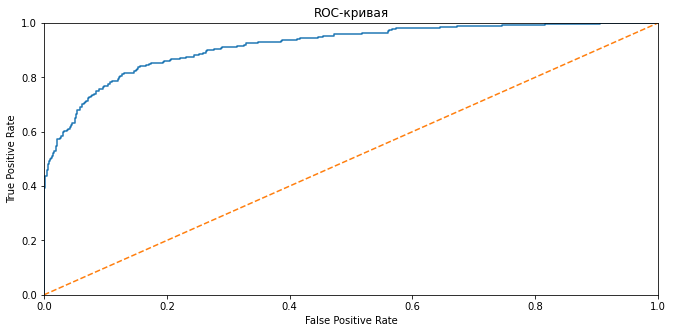

In [57]:
print('ROC-AUC score', roc_auc_score(y_test, Grid_CBC.predict_proba(X_test)[:, 1]))
    
fpr, tpr, thresholds = roc_curve(y_test, Grid_CBC.predict_proba(X_test)[:, 1])

plt.figure(figsize=(11, 5))   
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

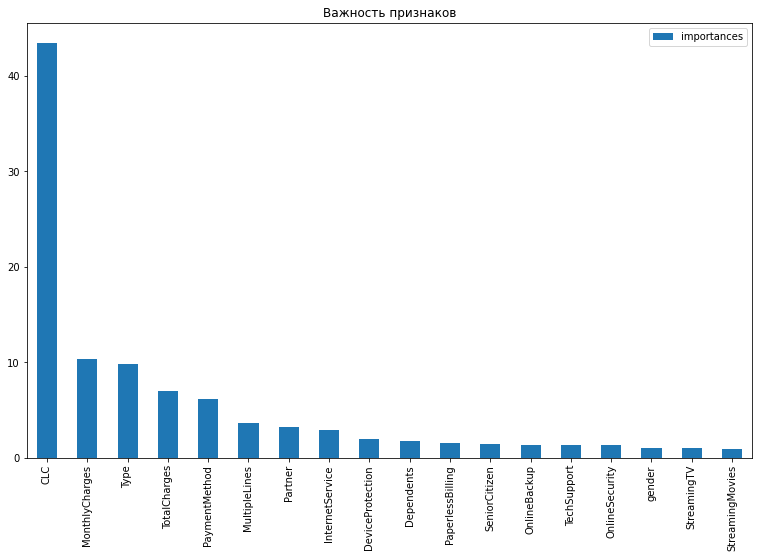

In [87]:
importances_df = pd.DataFrame(Grid_CBC.best_estimator_.get_feature_importance(), 
                              index = X_test.columns, 
                              columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df.plot(kind='bar', figsize=(13, 8), title='Важность признаков');

**Вывод**

На тесте катбуст показал ROC-AUC равным 0.9158812705815385, а самыми важными признаками оказались CLC, месячные выплаты и тип контракта

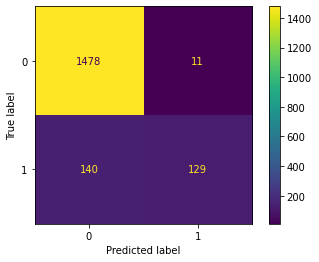

In [59]:
predictions = Grid_CBC.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=Grid_CBC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Grid_CBC.classes_)
disp.plot();

## Проверка Адекватности модели 

In [60]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])

0.4935549669072579

**Вывод**

Наша модель является адекватной, потому что показывает значительно лучшие результаты чем DummyClassifier

## Отчет 

**1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Был проведен EDA, в рамках которого я изучил все таблицы, распределения признаков и типы данных.

Затем я предобрабатывал данный в следующем порядке:
- Объединил все в один DataFrame.
- Заполнил пропуски в видах услуг, появившиеся после соединения.
- Добавил признак CLC(customer lifecycle) путем вычитания даты начала пользования услугами из даты окончания пользования услугами.
- Удалил данные с пропусками в TotalCharges (11 строк).
- Создал целевой признак Churn (0-клиент, 1-ушедший).
- Проверил корреляция признаков, т. к. она мешает обучению линейных моделей.

Далее я работал с выборками и создал:
- Тренировочная и тестовая выборки (75/25)
- Тренировочная и тестовая выборки с удаленными признаками с высокой корреляцией(TotalCharges, StreamingMovies, StreamingTV, InternetService) c типом кодировани OHE категориальных признаков и стандартизированными числовыми признаками(75/25)
- Тренировочная и тестовая выборки c типом кодировани OE категориальных признаков(75/25)

Потом я тестировал модели на кросс валидации:
- Логистическаяя регрессия с изменением C и penalty
- Catboost с изменением learning_rate, depth и l2_leaf_reg
- Случайный лес max_depth, min_samples_split, min_samples_leaf и n_estimators

Наилучшим образом себя показал Catboost, целевая метрика **ROC-AUG = 0.895**.
Проверка на тестовой выборке показала значение **ROC-AUG = 0.916**. Была изучена важность признаков и матрица ошибок.

Таким образом все пункты плана были выполнены

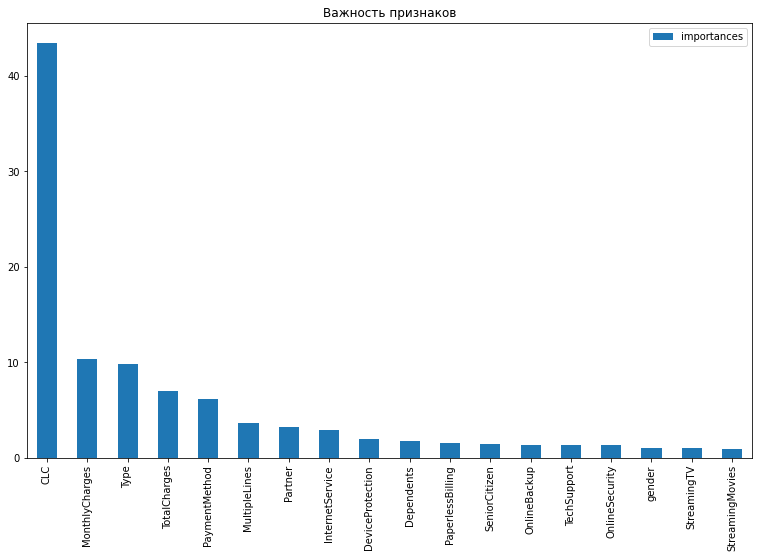

In [111]:
importances_df.plot(kind='bar', figsize=(13, 8), title='Важность признаков');

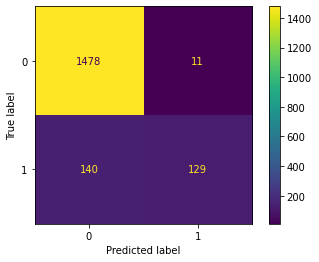

In [112]:
disp.plot();

**2. Какие трудности возникли и как вы их преодолели?**

Трудностей не возникло, планомерная работа.

**3. Какие ключевые шаги в решении задачи выделили?**
1. EDA
2. Предобработка и Фичеинжениринг
3. Создание выборок с разным типом кодирования
4. Перебор гиперпараметров на кросс-валидации, выбор лучшей модели
5. Анализ лучшей модели(важность признаков, матрица ошибок)
6. Проверка адекватности модели

**4. Какая итоговая модель, какие у нее гиперпараметры и какое качество**

**CatBoostClassifier** со следующими параметрами:
- iterations=300
- random_seed=250423
- cat_features=oe_features
- depth = 6
- l2_leaf_reg = 1
- learning_rate= 0.1

**ROC-AUC = 0.916**

In [113]:
Grid_CBC.best_params_

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [114]:
oe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

ROC-AUC score 0.9158812705815385


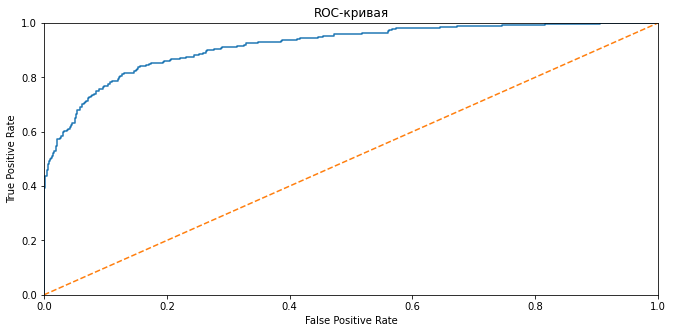

In [115]:
print('ROC-AUC score', roc_auc_score(y_test, Grid_CBC.predict_proba(X_test)[:, 1]))
    
fpr, tpr, thresholds = roc_curve(y_test, Grid_CBC.predict_proba(X_test)[:, 1])

plt.figure(figsize=(11, 5))   
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**5. Список признаков, используемых для обучения лучшей модели, описание их предобработки**


In [116]:
list(X_train.columns)

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'CLC']

Почти все эти признаки не требуют предобработки, однако есть исключения:
- CLC. Он образован путем вычитания даты начала пользования услугами из даты окончания пользования 
- Все категориальные признаки необходимо сообщить как аргумент cat_features при тренировке катбуста

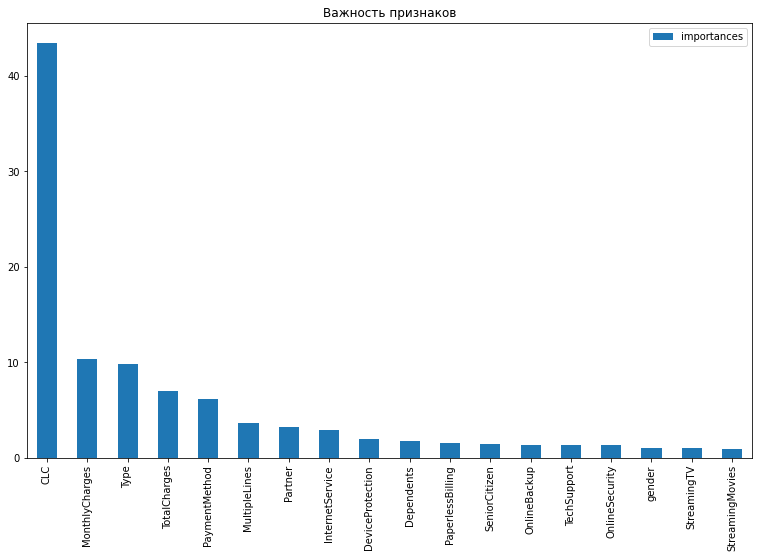

In [117]:
importances_df.plot(kind='bar', figsize=(13, 8), title='Важность признаков');